# Analyzing Data Sources

In [22]:
# Database Access
import pandas_datareader as web
import quandl as quandl
import wrds as wrds

# Utilities
from joblib import Parallel, delayed
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)
from multiprocessing import Pool, cpu_count
import warnings 
warnings.filterwarnings("ignore")
import os
import pandas as pd
import tqdm
from tqdm import tqdm
tqdm.pandas(desc="progress bar")

# Import time packages 
import time
import datetime
from dateutil.parser import parse

# Visualization Tools
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.io as pio

# Applying Settings to Viaualization Tools 
plt.rcParams['font.size'] = 13
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14


# Set the palette with different shades of blue
sns.set_palette(["#00204E", "#25587E", "#4182B0", "#5CAADF"])
# Rest of your code...
sns.set_palette(["#00204E", "#25587E", "#4182B0", "#5CAADF"])
sns.set_palette(["#001A41", "#1C4B6E", "#377B9C", "#52ABCA"])
plt.rcParams['font.family'] = 'Times New Roman'
sns.set_style("white")

# Linear Regression Packages 
from statsmodels.regression.rolling import RollingOLS

# Package to get the data from twitter
import snscrape.modules.twitter as sntwitter

# To stop processes from running
import signal
import time

INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [3]:
from utils import search_folder
current_dir = os.getcwd()
thesis_folder_path = current_dir.replace("/laptop code/thesis_code", "")
twitter_data_path = search_folder(thesis_folder_path,"twitter_data")
eikon_data_path = search_folder(thesis_folder_path,"eikon_news")
stock_data_path = search_folder(thesis_folder_path,"stock_prices")
modelling_data_path = search_folder(thesis_folder_path,"modelling_data")
google_trending_path = search_folder(thesis_folder_path,"google_search")
macrodata_path = search_folder(thesis_folder_path, "macroeconomic_data")

---
## 1.0 American Association of Individual Investors (AAII) sentiment index values.

Obtained from QUANDL 

In [4]:
quandl_key = 'CJ7iy2gX9gRyCJ9VTJNL'
sentiment_index = quandl.get('AAII/AAII_SENTIMENT', authtoken=quandl_key,
                             start_date='1987-07-01', end_date='2023-12-30')

In [5]:
sentiment_index = sentiment_index[["Bullish",	"Neutral",	"Bearish", "Bullish 8-Week Mov Avg"]]
sentiment_index = sentiment_index.reset_index()
sentiment_index = sentiment_index.rename(columns = {"Date": "datetime"})
sentiment_index = sentiment_index.fillna(0.0)
sentiment_index

,datetime,Bullish,Neutral,Bearish,Bullish 8-Week Mov Avg
0,1987-07-17,0.000000,0.000000,0.000000,0.000000
1,1987-07-24,0.360000,0.500000,0.140000,0.000000
2,1987-07-31,0.260000,0.480000,0.260000,0.000000
3,1987-08-07,0.560000,0.150000,0.290000,0.000000
4,1987-08-14,0.450000,0.350000,0.200000,0.000000
...,...,...,...,...,...
1756,2021-03-25,0.509494,0.284810,0.205696,0.450599
1757,2021-04-01,0.458333,0.309524,0.232143,0.451054
1758,2021-04-08,0.569079,0.226974,0.203947,0.457611
1759,2021-04-15,0.538206,0.215947,0.245847,0.460250


Text(0.5, 1.0, 'Quandl Sentiment Index')

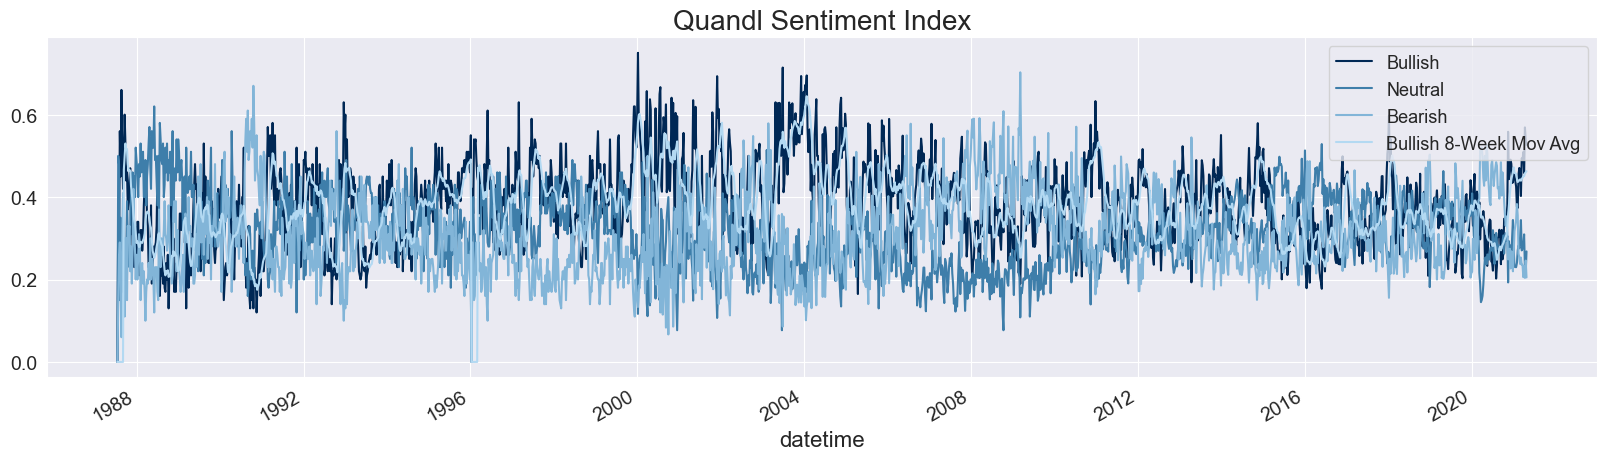

In [564]:
sentiment_index = sentiment_index.set_index(pd.to_datetime(sentiment_index.datetime))
sentiment_index = sentiment_index.sort_index(ascending=True)
sentiment_index[["Bullish",	"Neutral",	"Bearish", "Bullish 8-Week Mov Avg"]].plot(figsize = (20,5))
plt.title("Quandl Sentiment Index")

In [344]:
#sentiment_index.to_csv(modelling_data_path + "/quandl_sentiment_index.csv", index = False)

---
## 2.0 Twitter Data 
### Sns Scraping for Twitter

Released on July 8, 2020, snscrape is a scraping tool for social networking services (SNS). It scrapes things like users, user profiles, hashtags, searches, threads, list posts and returns the discovered items without using Twitter’s API.

In [3]:
### Helper Functions
def handle_twitter_account(user_name: str, add: bool):

    twitter_accounts_df = pd.read_csv(thesis_folder_path+"twitter_acounts.csv")

    if add == True: 
        if user_name not in list(twitter_accounts_df.twitter_accounts.values):
            new_row = pd.DataFrame({'twitter_accounts': [user_name]})
            twitter_accounts_df = pd.concat(
                [twitter_accounts_df, new_row], ignore_index=True)
            twitter_accounts_df = twitter_accounts_df.drop_duplicates()
            twitter_accounts_df.to_csv(thesis_folder_path+"/twitter_acounts.csv", index=False)
            print("Twitter User added")
        else:
            print("Twitter user name is already included")
    else:
        try: 
            df = df.drop(df[df['twitter_accounts'] == user_name].index)
            df.to_csv(thesis_folder_path+"/twitter_acounts.csv", index=False)
            print("User deleted from table")
        except Exception as e:
            print(e)

In [4]:
handle_twitter_account("opinion", True)

Twitter user name is already included


---
### Twitter Scraper Function 

In [4]:
def twitter_scraper(date_list: list, accounts_list: list, twitter_data_path : str, csv_name: str, query_subset: str): 
    
    """
    
    Scrapes Twitter data for a list of accounts and date ranges and saves the results to a CSV file.

    Args:
        date_list (list): A list of date ranges in the format "YYYY-MM-DD", where each pair of consecutive dates represents the start and end of a range.
        accounts_list (list): A list of Twitter account usernames to scrape data from.
        twitter_data_path (str): The file path to the directory where the CSV file will be saved.
        csv_name (str): The name of the CSV file to save the data to.
        query_subset (str): A string to append to the Twitter search query for each account, e.g. " covid".

    Returns:
        pandas.DataFrame: A DataFrame containing the scraped Twitter data.

    Raises:
        Exception: If the time limit for retrieving data from a single account (set to 10 minutes) is exceeded.

    Notes:
        - If the CSV file specified by 'csv_name' already exists, it will be loaded and used as the starting point for the scrape. If it doesn't exist, a new file with the specified column names will be created.
        - This function uses the 'sntwitter' package for scraping Twitter data.
    
    """
    
    # To cancell scraping 
    def handler(signum, frame):
        print("Time limit exceeded")
        raise Exception("Time limit exceeded")

    signal.signal(signal.SIGALRM, handler)
    
    twitter_columns=['datetime',
                     'username',
                     'text',
                     "rendered_content",
                     "likeCount",
                     "reply_count",
                     "retweet_count",
                     "retweeted",
                     "view_count"]
    
    try: # Checking wether file has already been initiated
        total_tweets_df = pd.read_csv(twitter_data_path+csv_name)
        print("CSV accessed")
    except:
        total_tweets_df = pd.DataFrame(columns = twitter_columns)
        total_tweets_df.to_csv(twitter_data_path+csv_name, index=False)
        print("CSV created")
                
    for date_idx in range(len(date_list)):
        for account in tqdm(accounts_list, dynamic_ncols=True):
            try:
                signal.alarm(10*60)  # 10 minutes to retrieve all of the data
                total_tweets_df = pd.read_csv(twitter_data_path+csv_name)
                query = f'from:{account}' + query_subset
                search_complete = str(f"{query} -filter:retweets since:{date_list[date_idx]} until:{date_list[date_idx+1]}")
                tweets_list = []

                for tweet in sntwitter.TwitterSearchScraper(search_complete).get_items():
                    tweets_list.append([tweet.date,
                                        tweet.user.username,
                                        tweet.rawContent,
                                        tweet.renderedContent,
                                        tweet.likeCount,
                                        tweet.replyCount,
                                        tweet.retweetCount,
                                        tweet.retweetedTweet,
                                        tweet.viewCount
                                        ])
                    
                tweets_df = pd.DataFrame(tweets_list, columns = twitter_columns)
                total_tweets_df = pd.concat([total_tweets_df, tweets_df])
                total_tweets_df = total_tweets_df.drop_duplicates()
                total_tweets_df.to_csv(twitter_data_path+csv_name, index=False)
                break_outer_loop = False
                if date_list[date_idx+1] == date_list[-1] and account == accounts_list[-1]:
                    break_outer_loop = True
                    break

            except Exception as e:
                if str(e) == "Time limit exceeded":
                    print(account)
                    continue  # skip to next iteration
                else:
                    print(f"Error occurred while scraping {account}: {e}")
            finally:
                # cancelling the timer after every iteration to reset it 
                signal.alarm(0)  
        
        if break_outer_loop:
            print("scraping done")
            break

    # After parsing through all of the years, cancell it. 
    signal.alarm(0)
    return pd.read_csv(twitter_data_path+csv_name)

In [ ]:
# Defining accounts to be used: 
twitter_accounts_df = pd.read_csv(thesis_folder_path+"twitter_acounts.csv")
accounts_list = list(twitter_accounts_df.twitter_accounts.unique())

# Defining arguments to scrape data for Tesla tweets  
csv_name_tesla = "/swissbank_stock_tweets_2.csv"
date_list = ["2017-01-01", "2018-01-01", "2019-01-01", "2020-01-01", "2021-01-01", "2022-01-01", "2023-04-10"]
query_subset = ' ($APPL OR #apple OR #APPLE)'

In [ ]:
tesla_tweets_df = twitter_scraper(date_list, accounts_list, twitter_data_path, csv_name_tesla, query_subset)

---
### Joining all twitter data

In [127]:
# Joining all tweets for all companies together 
tesla_df = pd.read_csv(twitter_data_path+ "/tesla_stock_tweets.csv")
tesla_df["company"] = "TSLA"
apple_df = pd.read_csv(twitter_data_path+ "/apple_stock_tweets.csv")
apple_df["company"] = "APPL"
moderna_df = pd.read_csv(twitter_data_path+ "/moderna_stock_tweets.csv")
moderna_df["company"] = "MRNA"
google_df = pd.read_csv(twitter_data_path+ "/google_stock_tweets.csv")
google_df["company"] = "GOOGL"
tweets_master_df = pd.concat([tesla_df, apple_df, moderna_df, google_df])

In [128]:
tweets_master_df

,datetime,username,text,rendered_content,likeCount,reply_count,retweet_count,retweeted,view_count,company
0,2017-01-01 00:05:05+00:00,marketexclusive,Analyst Activity – Robert W. Baird Reiterates ...,Analyst Activity – Robert W. Baird Reiterates ...,0.0,0.0,7.0,NaN,NaN,TSLA
1,2017-01-01 01:05:31+00:00,marketexclusive,Analyst Activity – Robert W. Baird Reiterates ...,Analyst Activity – Robert W. Baird Reiterates ...,0.0,0.0,5.0,NaN,NaN,TSLA
2,2017-01-01 01:09:50+00:00,evannex_com,"With #Tesla and #SolarCity combined, fossil fu...","With #Tesla and #SolarCity combined, fossil fu...",31.0,3.0,14.0,NaN,NaN,TSLA
3,2017-01-01 01:30:35+00:00,markcarson161,"$IBM Financials Updated Saturday, December 31,...","$IBM Financials Updated Saturday, December 31,...",0.0,0.0,1.0,NaN,NaN,TSLA
4,2017-01-01 01:51:22+00:00,teslaliving,8 new #Tesla #Superchargers found in the last ...,8 new #Tesla #Superchargers found in the last ...,4.0,0.0,4.0,NaN,NaN,TSLA
...,...,...,...,...,...,...,...,...,...,...
240686,2021-02-25 00:00:33+00:00,FRANCE24,Australia passes landmark law requiring Facebo...,Australia passes landmark law requiring Facebo...,29.0,1.0,5.0,NaN,NaN,GOOGL
240687,2021-02-16 09:21:33+00:00,FRANCE24,"In Australia, Google and Facebook may soon pay...","In Australia, Google and Facebook may soon pay...",15.0,0.0,3.0,NaN,NaN,GOOGL
240688,2021-01-21 10:03:06+00:00,FRANCE24,Google and French publishers sign landmark cop...,Google and French publishers sign landmark cop...,22.0,0.0,4.0,NaN,NaN,GOOGL
240689,2021-01-10 09:53:03+00:00,FRANCE24,Amazon to suspend US app Parler for ‘violent c...,Amazon to suspend US app Parler for ‘violent c...,72.0,7.0,27.0,NaN,NaN,GOOGL


---
# 3.0 Refinitiv News Headlines 

In [124]:
# Joining all tweets for all companies together 
tesla_reut_df = pd.read_excel(eikon_data_path+ "/tesla_eikon_news.xlsx")
tesla_reut_df["company"] = "TSLA"
apple_reut_df = pd.read_excel(eikon_data_path+ "/apple_eikon_news.xlsx")
apple_reut_df["company"] = "APPL"
moderna_reut_df = pd.read_excel(eikon_data_path+ "/moderna_eikon_news.xlsx")
moderna_reut_df["company"] = "MRNA"

In [125]:
reuts_master_df = pd.concat([tesla_reut_df, apple_reut_df, moderna_reut_df])
reuts_master_df = reuts_master_df.rename(columns= {"date ":"date"})
reuts_master_df["date"] = pd.to_datetime(reuts_master_df["date"])
reuts_master_df.insert(0,"datetime",reuts_master_df["date"].astype(str) + " " + reuts_master_df['hour'].astype(str))
reuts_master_df = reuts_master_df.drop(columns=["date", "hour"])

In [126]:
reuts_master_df.sort_values(by = "datetime")

,datetime,source,stock,text,company
19141,2017-01-01 12:44:28,ZOLCOM,AAPL.OQ,Apple Inc. (AAPL) Sees Large Drop in Short Int...,APPL
19140,2017-01-01 16:34:58,ZOLCOM,AAPL.OQ,"JLB & Associates Inc. Has $10,751,000 Position...",APPL
19139,2017-01-02 09:24:17,RTRS,.GDAXI .IBEX,German and French share indexes start 2017 on ...,APPL
19138,2017-01-02 09:52:42,RTRS,AAPL.O DLGS.DE,BUZZ-Dialog Semi: Falls on report Apple plans ...,APPL
18336,2017-01-02 22:54:59,AMEBAN,TSLA.OQ,"Tesla Motors, Inc. (TSLA) Downgraded by Vetr Inc.",TSLA
...,...,...,...,...,...
3,2023-04-07 16:24:11,RTRS,TSLA.O,UPDATE 1-Tesla recalls 422 U.S. vehicles over ...,TSLA
2,2023-04-07 18:23:42,RTRS,TSLA.O GM.N,Used U.S. electric vehicle sales jump as price...,TSLA
1,2023-04-07 19:02:55,BUSINT,TSLA.O,Tesla just flashed a sell signal that could sp...,TSLA
0,2023-04-07 20:17:22,SEECOM,IMG.TO PSMT.O,"Catalyst Watch: Eyes on inflation data, big ba...",MRNA


In [142]:
#reuts_master_df.to_csv(eikon_data_path+"/master_eikon_df.csv", index=False)

--- 
## 3.0 Google Trending data 

In [10]:
# Helper Functions for google search data
def clean_google_search(df, column_name):

    df = df.reset_index()
    df = df.drop(0)
    df = df.rename(
        columns={"index": "date", "Category: All categories": column_name})
    df["date"] = pd.to_datetime(df["date"])
    df = df.sort_values(by="date", ascending=True)
    df[column_name] = df[column_name].apply(
        lambda x: 0 if x == '<1' else int(x))
    df["rolling_"+column_name] = df[column_name].rolling(2).mean()
    df = df.fillna(0.0)
    return df

### Historical Company Interest

In [11]:
df_apple_searches = pd.read_csv(google_trending_path + "/apple_interest.csv")
df_apple_searches["company"] = "apple"
df_apple_searches["interest"] = df_apple_searches.apple_interest
df_apple_searches = df_apple_searches[["date", "interest", "company"]]

In [12]:
df_moderna_searches = pd.read_csv(google_trending_path + "/moderna_interest.csv")
df_moderna_searches["company"] = "moderna"
df_moderna_searches["interest"] = df_moderna_searches.moderna_mentions
df_moderna_searches = df_moderna_searches[["date", "interest", "company"]]

In [13]:
df_tesla_searches = pd.read_csv(google_trending_path + "/tesla_interest.csv")
df_tesla_searches["company"] = "tesla"
df_tesla_searches["interest"] = df_tesla_searches.tesla_mentions
df_tesla_searches = df_tesla_searches[["date", "interest", "company"]]

In [14]:
company_google_search_df = pd.concat([df_tesla_searches, df_moderna_searches, df_apple_searches])
company_google_search_df["date"] = pd.to_datetime(company_google_search_df["date"])
company_google_search_df = company_google_search_df.rename(columns = {"date":"datetime"})
company_google_search_df

,datetime,interest,company
0,2018-04-15,18,tesla
1,2018-04-22,16,tesla
2,2018-04-29,20,tesla
3,2018-05-06,20,tesla
4,2018-05-13,19,tesla
...,...,...,...
256,2023-03-05,38,apple
257,2023-03-12,37,apple
258,2023-03-19,37,apple
259,2023-03-26,37,apple


In [15]:
list(company_google_search_df.company.unique())

['tesla', 'moderna', 'apple']

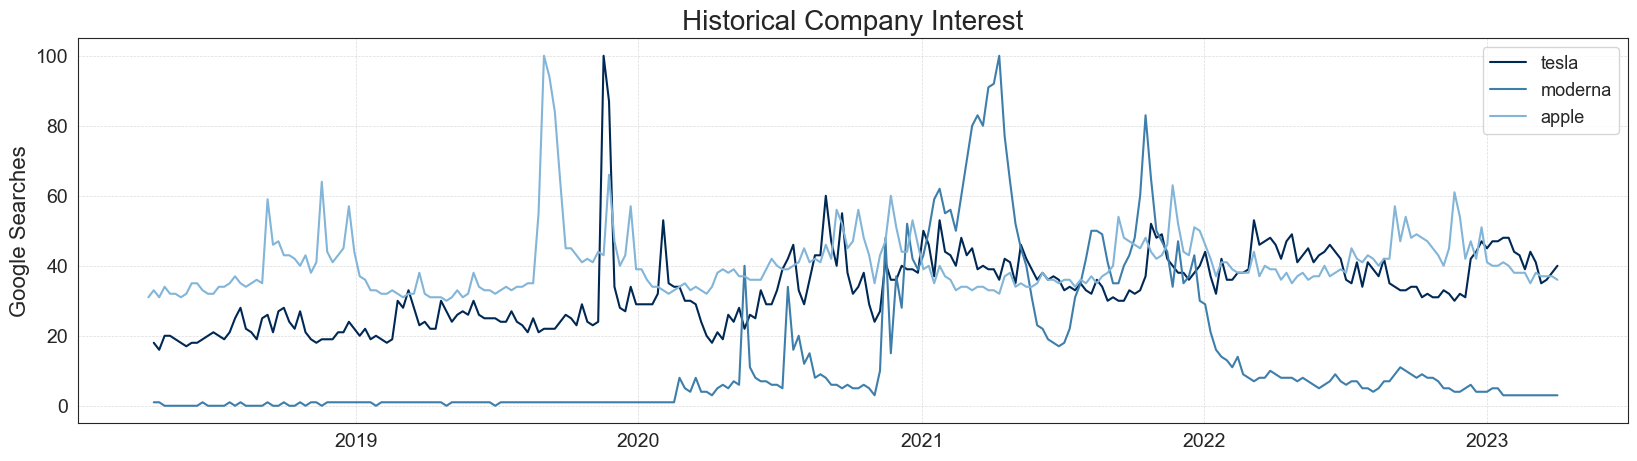

In [27]:
plt.figure(figsize = (20,5))
for comp in list(company_google_search_df.company.unique()):
    company_selection = company_google_search_df[company_google_search_df["company"] == comp]
    plt.plot(company_selection.datetime, company_selection.interest)

plt.legend(["tesla", "moderna", "apple"])
plt.ylabel("Google Searches")
plt.title("Historical Company Interest")
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.show()

In [739]:
company_google_search_df.to_csv(modelling_data_path+ "/google_searches_companies.csv", index = False)

---
### Macro-economig Indicators

In [23]:
# Pandemic Mentions 
df_pandemic_searches = pd.read_csv(google_trending_path+ "/pandemic_mentions.csv")
df_pandemic_searches["company"] = "all"
df_pandemic_searches = df_pandemic_searches[["date", "pandemic_mentions", "company"]]

In [24]:
# Inflation Mentions 
df_inflation_searches = pd.read_csv(google_trending_path+ "/inflation_interest.csv")
df_inflation_searches["company"] = "all"
df_inflation_searches = df_inflation_searches.rename(columns = {"interest_over_time" : "inflation_mentions"})
df_inflation_searches = df_inflation_searches[["date", "inflation_mentions", "company"]]

In [25]:
google_search_macro_df = pd.merge(df_pandemic_searches[["date", "pandemic_mentions"]], df_inflation_searches[["date","inflation_mentions"]], on = "date", how = "inner")
google_search_macro_df["date"] = pd.to_datetime(google_search_macro_df["date"])
google_search_macro_df = google_search_macro_df.rename(columns = {"date":"datetime"})

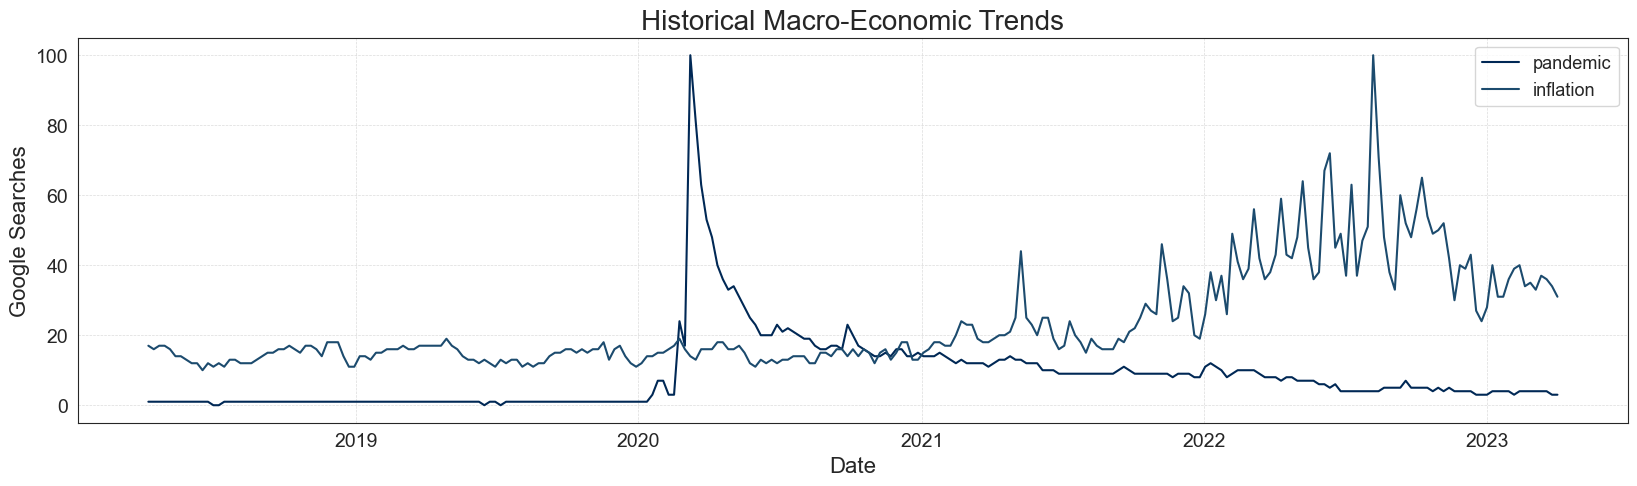

In [96]:
plt.figure(figsize = (20,5))
plt.plot(google_search_macro_df.datetime, google_search_macro_df.pandemic_mentions)
plt.plot(google_search_macro_df.datetime, google_search_macro_df.inflation_mentions)
plt.legend(["pandemic", "inflation"])
plt.xlabel("Date")
plt.ylabel("Google Searches")
plt.title("Historical Macro-Economic Trends")
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.show()

In [728]:
#google_search_macro_df.to_csv(modelling_data_path + "/google_macro_searches.csv", index = False)

---
## 4.0 Publicly Available datasets 

1. Tweets about Top Companies from 2015 to 2020 link: https://www.kaggle.com/datasets/omermetinn/tweets-about-the-top-companies-from-2015-to-2020


In [443]:
tweet_id_df = pd.read_csv(r"/Users/diegozucchino/Library/CloudStorage/OneDrive-Personal/Frankfurt School Courses/fourth_semester/master_thesis_FS/output_data/thesis_datasets/biggest_companies_tweets_kaggle/Company_Tweet.csv")
tweet_info_df = pd.read_csv(r"/Users/diegozucchino/Library/CloudStorage/OneDrive-Personal/Frankfurt School Courses/fourth_semester/master_thesis_FS/output_data/thesis_datasets/biggest_companies_tweets_kaggle/Tweet.csv")

In [444]:
tweet_id_df.ticker_symbol.value_counts()

AAPL     1425013
TSLA     1096868
AMZN      718715
GOOG      392569
MSFT      375711
GOOGL     327569
Name: ticker_symbol, dtype: int64

In [447]:
tweet_info_df.writer.value_counts().sort_values(ascending=False)

App_sw_           91741
_peripherals      91461
computer_hware    90919
It_c0nsulting     75270
PortfolioBuzz     59838
                  ...  
4minuteMiler          1
lyyvictor             1
Haux49                1
HcDiane               1
QuantVal              1
Name: writer, Length: 140131, dtype: int64

In [253]:
biggest_companies_tweets = pd.merge(tweet_info_df, tweet_id_df, how="left", on="tweet_id")
biggest_companies_tweets["post_date"] = biggest_companies_tweets.post_date.apply(lambda x: datetime.datetime.fromtimestamp(x))
biggest_companies_tweets.head()

,tweet_id,writer,post_date,body,comment_num,retweet_num,like_num,ticker_symbol
0,550441509175443456,VisualStockRSRC,2015-01-01 01:00:57,"lx21 made $10,008 on $AAPL -Check it out! htt...",0,0,1,AAPL
1,550441672312512512,KeralaGuy77,2015-01-01 01:01:36,Insanity of today weirdo massive selling. $aap...,0,0,0,AAPL
2,550441732014223360,DozenStocks,2015-01-01 01:01:50,S&P100 #Stocks Performance $HD $LOW $SBUX $TGT...,0,0,0,AMZN
3,550442977802207232,ShowDreamCar,2015-01-01 01:06:47,$GM $TSLA: Volkswagen Pushes 2014 Record Recal...,0,0,1,TSLA
4,550443807834402816,i_Know_First,2015-01-01 01:10:05,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1,AAPL


---
## 5.0 Fama French Model and Beta Sensitivity Analysis 

#### In case I am interested in calculating future returns, and not stock only price necessarily, one could used the following varibles:

- Calculation of the beta coefficients for the Fama-French 5-factor model.

- The beta coefficients in the Fama-French 5-factor model measure the sensitivity of a stock's returns to changes in each of the five factors. Market risk (MKT-RF), size (SMB), value (HML), profitability (RMW), and investment (CMA). Specifically, the beta coefficient for a factor measures the change in the stock's expected return for a 1% change in the corresponding factor.

- By estimating the beta coefficients for a stock, the Fama-French 5-factor model can be used to predict the stock's expected returns based on its sensitivity to the five factors. These predicted returns can then be compared to the actual returns to determine whether the stock is overvalued or undervalued relative to its expected returns. This allows investors to make informed decisions about whether to buy, hold, or sell a particular stock, based on its expected performance relative to the market and other stocks.

In [28]:
# Download the Fama French factors and put them into one DataFrame
startdt = datetime.datetime(2016, 1, 1)

# Each of the following below represents
d1 = web.DataReader('F-F_Research_Data_Factors_daily', 'famafrench',
                    start=startdt)  # d1 = fama french 3 factor model
d2 = web.DataReader('F-F_Momentum_Factor_daily', 'famafrench',
                    start=startdt)  # d2 = fama french 4 factor model
d3 = web.DataReader('F-F_Research_Data_5_Factors_2x3_daily',
                    'famafrench', start=startdt)  # d3 = fama french 5 factor model

# Getting Fama French Factors
ff = d1[0]/100
ff = ff.join(d2[0]/100, how='left')
ff5 = d3[0]/100
ff5 = ff.join(ff5.loc[:, ['RMW', 'CMA']], how='left')
#
ff5.columns = [z.lower().strip() for z in ff5.columns]
ff5.rename(columns={'mkt-rf': 'mktrf'}, inplace=True)
#
fama_french_5factor = ff5.loc[:, [
    'mktrf', 'smb', 'hml', 'mom', 'rmw', 'cma', 'rf']]


In [29]:
fama_french_5factor

,mktrf,smb,hml,mom,rmw,cma,rf
Date,,,,,,,
2016-01-04,-0.0159,-0.0087,0.0052,-0.0193,0.0036,0.0040,0.00000
2016-01-05,0.0012,-0.0019,0.0001,0.0067,0.0005,0.0031,0.00000
2016-01-06,-0.0135,-0.0014,0.0000,0.0192,0.0015,0.0004,0.00000
2016-01-07,-0.0244,-0.0029,0.0008,0.0086,0.0049,0.0036,0.00000
2016-01-08,-0.0111,-0.0049,-0.0003,-0.0011,0.0024,0.0006,0.00000
...,...,...,...,...,...,...,...
2023-04-24,0.0000,-0.0040,0.0047,0.0045,0.0066,0.0028,0.00018
2023-04-25,-0.0176,-0.0099,0.0010,0.0110,0.0044,0.0089,0.00018
2023-04-26,-0.0041,0.0015,-0.0075,-0.0050,0.0005,-0.0033,0.00018


---
### 5.1 Calculating returns for the selected stocks:



The following list includes the company name and the selected permno: 

- Apple Inc.
- Moderna
- Tesla

In [115]:
moderna_stock = pd.read_excel(stock_data_path+ "/moderna_historical_prices.xlsx")
moderna_stock["company"] = "moderna"
apple_stock = pd.read_excel(stock_data_path+ "/apple_historical_prices.xlsx")
apple_stock["company"] = "apple"
tesla_stock = pd.read_excel(stock_data_path+ "/tesla_historical_prices.xlsx")
tesla_stock["company"] = "tesla"
#mrna_stock = pd.read_excel(stock_data_path+ "/google_historical_prices.xlsx")

In [116]:
stocks_master_df

,datetime,close,net,ret,open,low,high,volume,turnover_usd,flow,company
1575,2017-01-03,14.465986,NaN,NaN,14.323986,14.063986,14.688652,8.884890e+07,1.283684e+09,0.000000e+00,tesla
1575,2017-01-03,29.037500,NaN,NaN,28.950000,28.690000,29.082500,1.151275e+08,3.327549e+09,0.000000e+00,apple
1574,2017-01-04,29.005000,-0.032500,-0.001119,28.962500,28.937500,29.127500,8.447246e+07,2.452484e+09,-2.452484e+09,apple
1574,2017-01-04,15.132652,0.666666,0.046085,14.316652,14.287319,15.199985,1.682022e+08,2.511866e+09,2.511866e+09,tesla
1573,2017-01-05,29.152500,0.147500,0.005085,28.980000,28.952500,29.216050,8.877435e+07,2.584690e+09,1.322059e+08,apple
...,...,...,...,...,...,...,...,...,...,...,...
28,2023-02-27,147.920000,1.210000,0.008248,147.710000,147.450000,149.170000,4.499847e+07,6.665823e+09,4.020613e+11,apple
28,2023-02-27,138.270000,-0.990000,-0.007109,139.520000,136.720000,140.910000,4.965970e+06,6.894097e+08,5.894183e+10,moderna
27,2023-02-28,205.710000,-1.920000,-0.009247,210.590000,203.750000,211.230000,1.531449e+08,3.171329e+10,2.040832e+12,tesla
27,2023-02-28,147.410000,-0.510000,-0.003448,147.050000,146.830000,149.080000,5.054700e+07,7.470828e+09,3.945905e+11,apple


In [31]:
stocks_master_df = pd.concat([moderna_stock, apple_stock, tesla_stock])

In [55]:
stocks_master_df = stocks_master_df.rename(columns = {"Exchange Date" : "datetime",
                                                      "%Chg" : "ret", 
                                                      "turnover - usd": "turnover_usd"})
stocks_master_df = stocks_master_df.rename(columns = str.lower)
stocks_master_df['datetime'] = pd.to_datetime(stocks_master_df['datetime'])
stocks_master_df = stocks_master_df[stocks_master_df["datetime"] <= "2023-02-28"]
stocks_master_df = stocks_master_df.sort_values(by = "datetime", ascending= True)

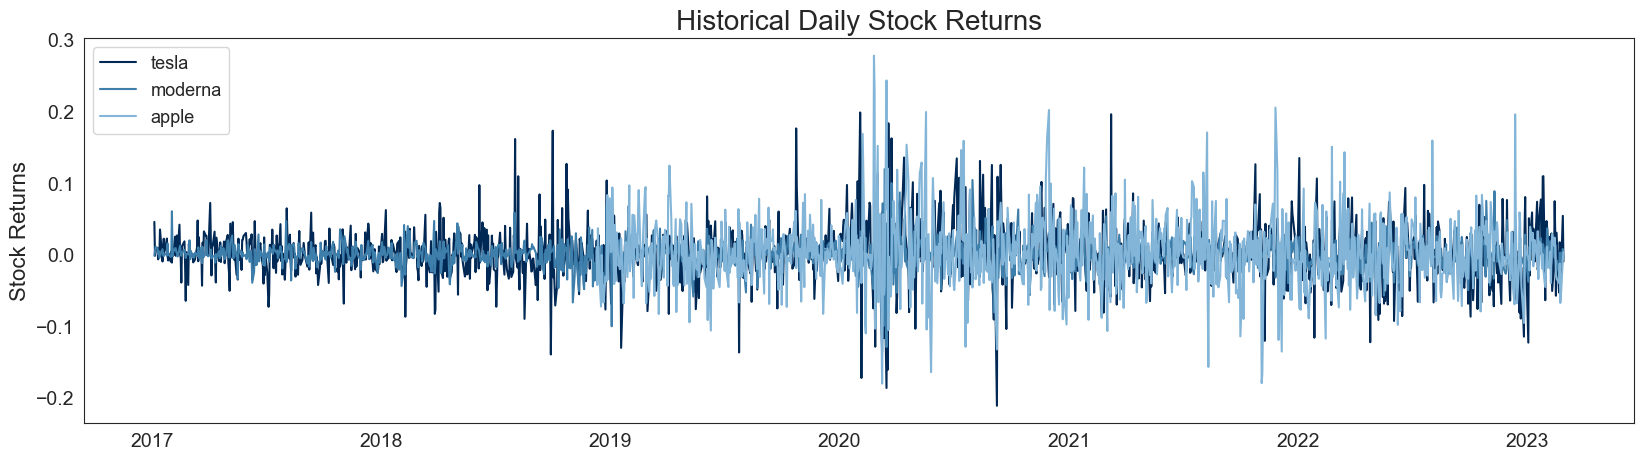

In [57]:
plt.figure(figsize = (20,5))
for comp in list(stocks_master_df.company.unique()):
    company_selection = stocks_master_df[stocks_master_df["company"] == comp]
    plt.plot(company_selection.datetime, company_selection.ret)
plt.legend(["tesla", "moderna", "apple"])
plt.ylabel("Stock Returns")
plt.title("Historical Daily Stock Returns")
plt.show()

In [58]:
list(stocks_master_df.company.unique())

['tesla', 'apple', 'moderna']

In [60]:
company_selection

,datetime,close,net,ret,open,low,high,volume,turnover_usd,flow,company
1575,2017-01-03,14.465986,NaN,NaN,14.323986,14.063986,14.688652,8.884890e+07,1.283684e+09,0.000000e+00,tesla
1574,2017-01-04,15.132652,0.666666,0.046085,14.316652,14.287319,15.199985,1.682022e+08,2.511866e+09,2.511866e+09,tesla
1573,2017-01-05,15.116652,-0.016000,-0.001057,15.094652,14.796652,15.165318,8.867551e+07,1.326627e+09,1.185238e+09,tesla
1572,2017-01-06,15.267318,0.150666,0.009967,15.128652,15.029985,15.353985,8.291848e+07,1.263700e+09,2.448938e+09,tesla
1571,2017-01-09,15.418651,0.151333,0.009912,15.264651,15.199985,15.461318,5.969232e+07,9.167606e+08,3.365699e+09,tesla
...,...,...,...,...,...,...,...,...,...,...,...
31,2023-02-22,200.860000,3.490000,0.017683,197.930000,191.780000,201.990000,1.918285e+08,3.787873e+10,2.037773e+12,tesla
30,2023-02-23,202.070000,1.210000,0.006024,203.910000,196.330000,205.140000,1.463600e+08,2.936556e+10,2.067138e+12,tesla
29,2023-02-24,196.880000,-5.190000,-0.025684,196.325000,192.800000,197.669500,1.422281e+08,2.781627e+10,2.039322e+12,tesla
28,2023-02-27,207.630000,10.750000,0.054602,202.030000,201.260000,209.420000,1.610283e+08,3.322295e+10,2.072545e+12,tesla


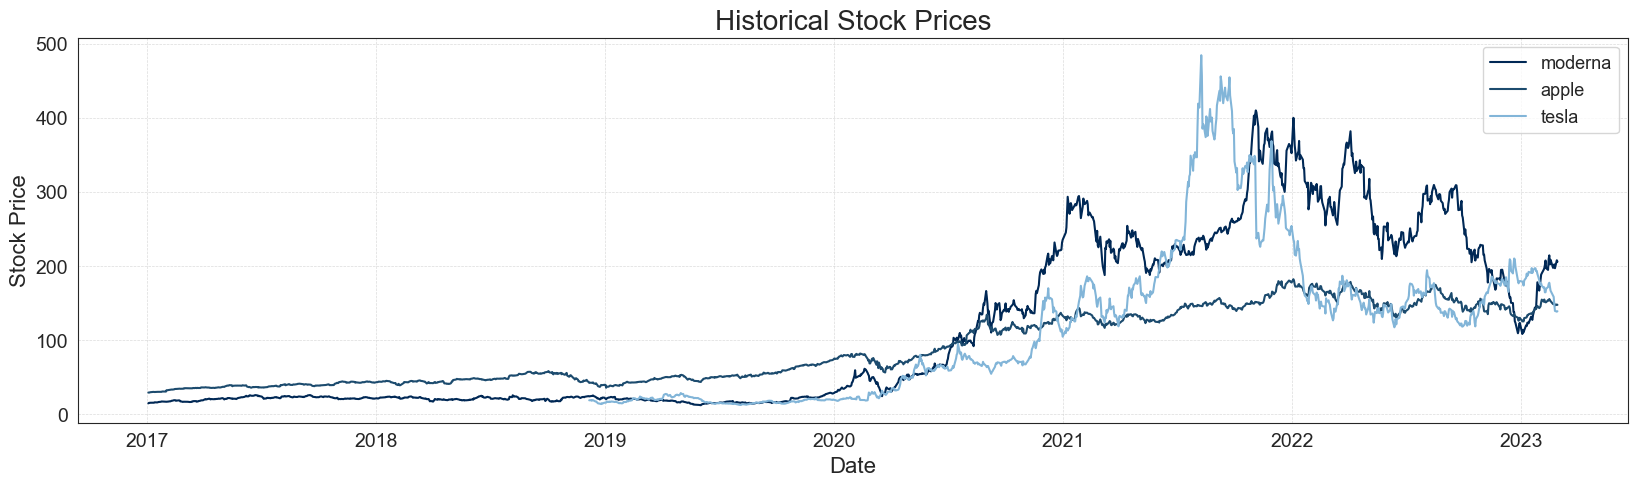

In [98]:
plt.figure(figsize = (20,5))
for comp in list(stocks_master_df.company.unique()):
    company_selection = stocks_master_df[stocks_master_df["company"] == comp]
    plt.plot(company_selection.datetime, company_selection.close)
plt.legend(["moderna", "apple", "tesla"])
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("Historical Stock Prices")
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.show()

In [825]:
#stocks_master_df.to_csv(modelling_data_path+ "/all_stocks_returns_df.csv", index = False)

---
- The belowcode is now preparing data for a factor analysis of stock returns using the Fama-French 5-factor model.

- The first step involves selecting the daily stock returns for a list of specified companies and storing the data in a pandas dataframe called stocks_master_df_2. 

- The code then calculates excess returns by subtracting the risk-free rate from each stock's returns.

- Next, the code loads data for the Fama-French 5-factor model (including market risk, size, value, profitability, and investment factors) and merges this data with the excess returns dataframe. The resulting dataframe (df_ret) contains excess returns and factor data for the specified stocks, which can be used to estimate the factor betas and conduct further analysis.

In [79]:
# factor betas
# create a slimmer copy for work
cols2use = ['company', 'datetime', 'ret']
stocks_master_df_2 = stocks_master_df[cols2use].copy().set_index(['datetime', 'company']).sort_index()

df_ret = stocks_master_df_2['ret'].unstack()
universe = list(df_ret.columns)

# subtract risk-free rate from returns to get excess returns idx = df_ret.indexdf_ret = df_ret.subtract(ff.loc[idx, 'rf'], axis=0)
idx = df_ret.index

df_ret = df_ret.subtract(fama_french_5factor.loc[idx, 'rf'], axis=0)

# merge to include factors
factors = ['mktrf', 'smb', 'hml', 'mom', "rmw", 'cma', "rf"]
df_ret = df_ret.merge(fama_french_5factor.loc[idx, factors], on='datetime')


In [80]:
df_ret

,apple,moderna,tesla,mktrf,smb,hml,mom,rmw,cma,rf
datetime,,,,,,,,,,
2017-01-03,NaN,NaN,NaN,0.0083,-0.0013,0.0005,-0.0061,-0.0021,0.0026,0.00002
2017-01-04,-0.001139,NaN,0.046065,0.0079,0.0095,-0.0016,-0.0037,-0.0047,-0.0004,0.00002
2017-01-05,0.005065,NaN,-0.001077,-0.0021,-0.0088,-0.0079,-0.0060,-0.0022,-0.0008,0.00002
2017-01-06,0.011128,NaN,0.009947,0.0029,-0.0066,-0.0031,-0.0018,-0.0035,-0.0030,0.00002
2017-01-09,0.009140,NaN,0.009892,-0.0037,-0.0029,-0.0104,-0.0037,0.0014,-0.0052,0.00002
...,...,...,...,...,...,...,...,...,...,...
2023-02-22,0.002716,-0.012173,0.017503,-0.0004,0.0055,-0.0043,-0.0056,-0.0038,-0.0040,0.00018
2023-02-23,0.003111,-0.067197,0.005844,0.0046,0.0021,-0.0023,0.0006,-0.0002,-0.0040,0.00018
2023-02-24,-0.018185,-0.056492,-0.025864,-0.0109,-0.0049,0.0126,0.0121,0.0022,0.0034,0.00018


---
- The below code code defines a function called get_beta_bypermno() that calculates the beta coefficients for a given stock (specified by company) using a rolling regression approach with a specified window size and minimum number of observations.
- The function takes as input a pandas dataframe containing stock returns data (stored in the df variable), as well as optional arguments for the company value, window size, minimum number of observations, and factor model to use (either Fama-French 4-factor or 5-factor model).

In [85]:
def get_beta_bypermno(df, company, window, min_n, factor_model):
    
    """Calculates the rolling regression betas of a security or portfolio against one or more factor models using the Fama-French methodology.

    Args:
        df (pandas.DataFrame): DataFrame containing the returns of the security or portfolio of interest and the factor returns.
        company (str, optional): Name of the column in `df` that contains the returns of the security or portfolio of interest. Defaults to None.
        window (int, optional): Length of the rolling window (in trading days). Defaults to 63.
        min_n (int, optional): Minimum number of observations required to compute a beta. Defaults to 10.
        factor_model (str, optional): Name of the Fama-French factor model to use ('ff4' or 'ff5'). Defaults to none.

    Returns:
        pandas.DataFrame: DataFrame containing the rolling betas and rolling standard errors for each factor in the specified factor model, as well as the risk-free rate of return. The `company` column is added to identify which security or portfolio the betas correspond to.
    """

    if (company is not None) and (company in df.columns):
        df = df.rename(columns={company: 'ret'})
    else:
        print(f'permno {company} not in the data')

    if factor_model == 'ff5':
        formula = f'ret ~ 1 +  mktrf + smb + hml + rmw + cma'

    rres = RollingOLS.from_formula(formula,
                                   data=df,
                                   window=window,
                                   min_nobs=min_n,
                                   missing='drop').fit(params_only=False)
    temp_beta = rres.params.iloc[:, 1:]
    temp_beta.columns = [f'beta_{z}' for z in temp_beta.columns]
    temp_beta = temp_beta.join(
        (rres.mse_resid.to_frame(f'idvar_{factor_model}')*252))
    temp_beta['company'] = company
    temp_beta = temp_beta.dropna(axis=1, how='all')
    return temp_beta.reset_index()

In [86]:
fama_french_beta_sensibility = pd.DataFrame()
for company in tqdm(list(stocks_master_df.company)):
    fama_french_beta_sensibility = pd.concat([fama_french_beta_sensibility, get_beta_bypermno(
        df_ret, company, window=3*21, min_n=int(21/2), factor_model='ff5')])


100%|██████████| 4161/4161 [14:11<00:00,  4.89it/s]


In [87]:
fama_french_beta_sensibility["datetime"] = pd.to_datetime(fama_french_beta_sensibility["datetime"])
fama_french_beta_sensibility

,datetime,beta_mktrf,beta_smb,beta_hml,beta_rmw,beta_cma,idvar_ff5,company
0,2017-01-03,NaN,NaN,NaN,NaN,NaN,NaN,tesla
1,2017-01-04,NaN,NaN,NaN,NaN,NaN,NaN,tesla
2,2017-01-05,NaN,NaN,NaN,NaN,NaN,NaN,tesla
3,2017-01-06,NaN,NaN,NaN,NaN,NaN,NaN,tesla
4,2017-01-09,NaN,NaN,NaN,NaN,NaN,NaN,tesla
...,...,...,...,...,...,...,...,...
1544,2023-02-22,0.426955,-0.268995,-1.131067,-0.161699,-0.522605,0.347013,moderna
1545,2023-02-23,0.467319,-0.317175,-1.269439,-0.325064,-0.147053,0.368480,moderna
1546,2023-02-24,0.480168,-0.236197,-1.593003,-0.452391,0.303459,0.370515,moderna
1547,2023-02-27,0.511279,-0.389964,-1.713011,-0.646594,0.449467,0.366221,moderna


In [117]:
fama_french_beta_sensibility["datetime"] = pd.to_datetime(fama_french_beta_sensibility["datetime"])
fama_french_beta_sensibility

,datetime,beta_mktrf,beta_smb,beta_hml,beta_rmw,beta_cma,idvar_ff5,company
0,2017-01-03,NaN,NaN,NaN,NaN,NaN,NaN,moderna
1,2017-01-04,NaN,NaN,NaN,NaN,NaN,NaN,moderna
2,2017-01-05,NaN,NaN,NaN,NaN,NaN,NaN,moderna
3,2017-01-06,NaN,NaN,NaN,NaN,NaN,NaN,moderna
4,2017-01-09,NaN,NaN,NaN,NaN,NaN,NaN,moderna
...,...,...,...,...,...,...,...,...
1544,2023-02-22,-0.098824,-1.196808,1.684527,-1.405257,-6.728978,0.337141,tesla
1545,2023-02-23,-0.061732,-1.207136,1.637407,-1.471334,-6.525388,0.337556,tesla
1546,2023-02-24,0.006477,-1.221557,1.446724,-1.413936,-6.323183,0.340983,tesla
1547,2023-02-27,-0.053175,-1.000105,1.641799,-1.060359,-6.648764,0.336822,tesla


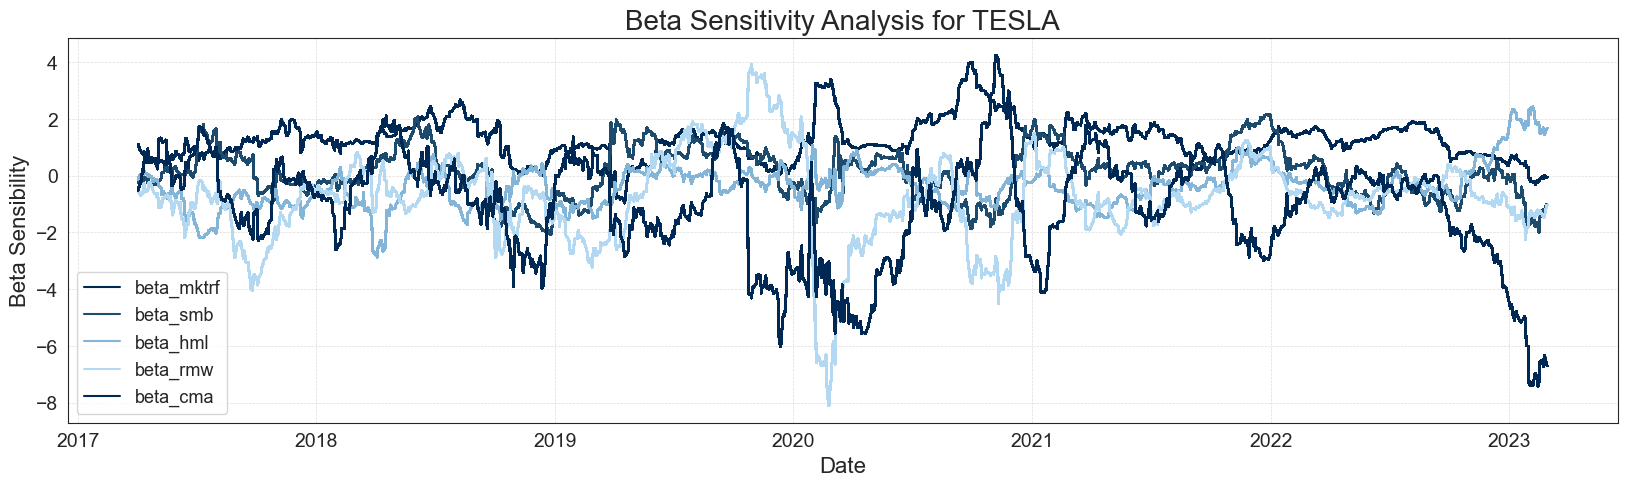

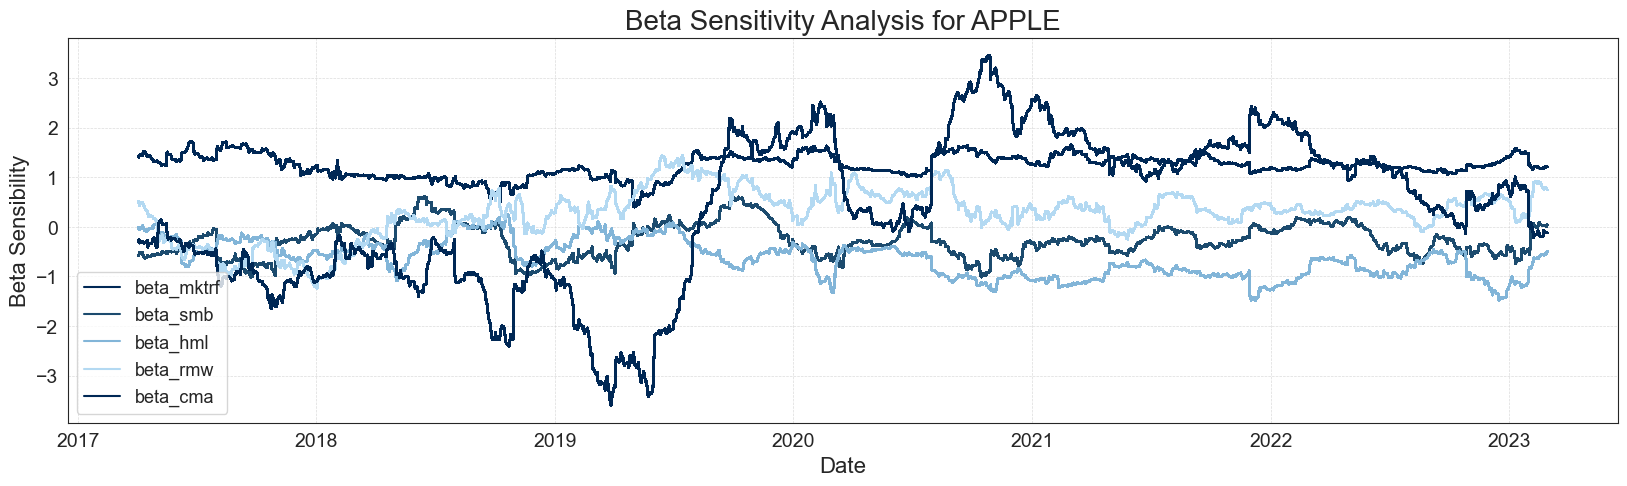

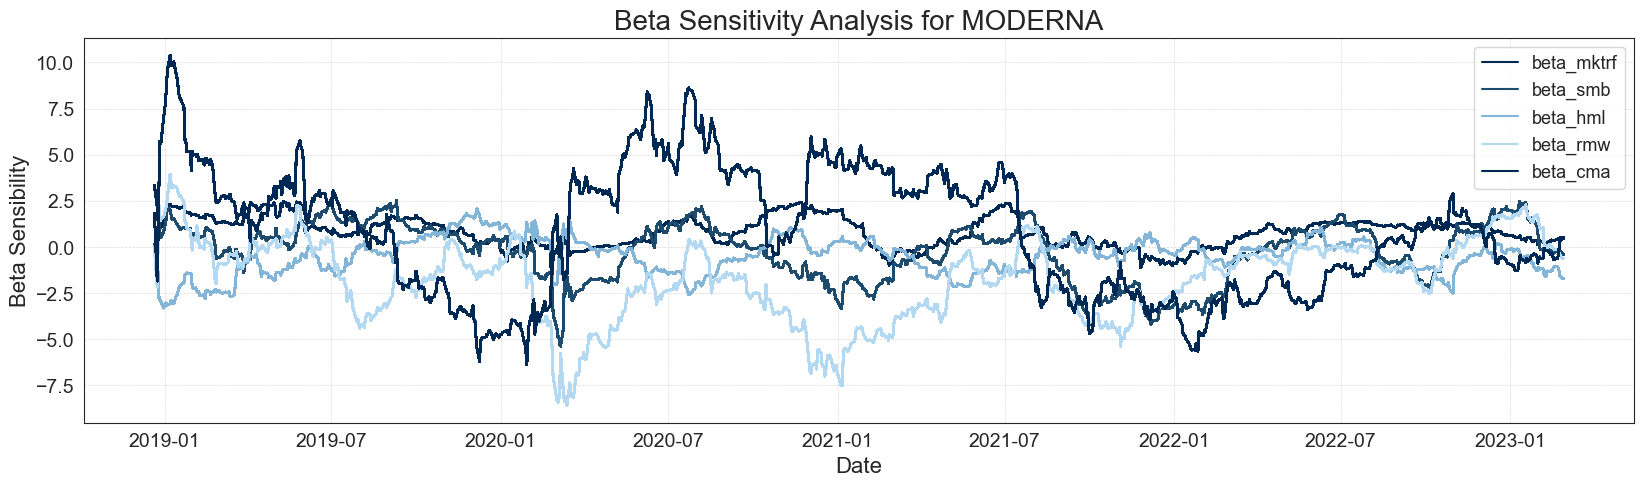

In [94]:
for company in list(fama_french_beta_sensibility.company.unique()):
    company_selection = fama_french_beta_sensibility[fama_french_beta_sensibility["company"] == company]
    plt.figure(figsize=(20, 5))
    plt.title("Beta Sensitivity Analysis for " + company.upper())
    plt.plot(company_selection["datetime"], company_selection.iloc[:, 1:6])
    plt.legend(list(company_selection.iloc[:, 1:6].columns))
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    plt.xlabel("Date")
    plt.ylabel("Beta Sensibility")
    plt.show()

In [290]:
#fama_french_beta_sensibility.to_csv(modelling_data_path + "/fama_variables_companies.csv", index = False)

---
## 6. Macro-Economic Data

### Nasdaq Historical Returns

In [89]:
nasdaq_index_df = pd.read_excel(macrodata_path + "/nasdaq_index_historical_prices.xlsx")

In [91]:
nasdaq_index_df = nasdaq_index_df.rename(columns = str.lower)
nasdaq_index_df = nasdaq_index_df.rename(columns = {
                                                      "net" : "nasdaqd_net",
                                                      "%chg" : "nasdaqd_ret",
                                                      "turnover - usd": "nasdaq_turnover_usd",
                                                      "high" : "nasdaq_high",
                                                      "low" : "nasdaq_low",
                                                      "open" : "nasdaq_open",
                                                      "close": "nasdaq_close",
                                                      "volume": "nasdaq_volume",
                                                      "exchange date" : "datetime"})
nasdaq_index_df['datetime'] = pd.to_datetime(nasdaq_index_df['datetime'])

In [92]:
nasdaq_index_df

,datetime,nasdaq_close,nasdaqd_net,nasdaqd_ret,nasdaq_open,nasdaq_low,nasdaq_high,nasdaq_volume
0,2023-04-06,13062.596,95.397,0.007357,12892.899,12846.028,13078.101,229514980
1,2023-04-05,12967.199,-132.876,-0.010143,13056.791,12894.442,13065.275,247235519
2,2023-04-04,13100.075,-48.275,-0.003672,13148.350,13049.977,13204.078,227660972
3,2023-04-03,13148.350,-33.001,-0.002504,13084.096,13036.548,13157.474,247213043
4,2023-03-31,13181.351,218.209,0.016833,12968.958,12968.003,13188.833,317692659
...,...,...,...,...,...,...,...,...
1571,2017-01-09,5024.899,17.822,0.003559,5013.820,5009.451,5033.321,140374244
1572,2017-01-06,5007.077,42.124,0.008484,4973.868,4957.821,5020.699,131384869
1573,2017-01-05,4964.953,27.748,0.005620,4936.355,4935.343,4967.901,140485654
1574,2017-01-04,4937.205,25.871,0.005268,4920.792,4919.803,4944.745,141126335


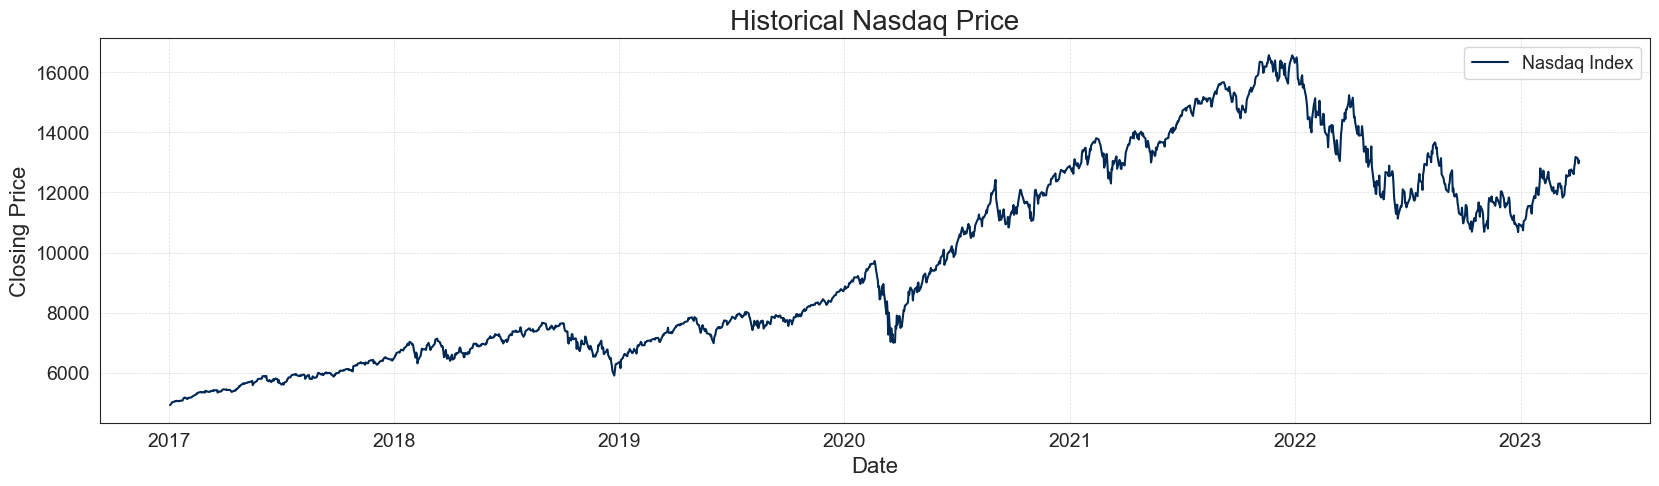

In [101]:
plt.figure(figsize=(20, 5))
plt.title("Historical Nasdaq Price")
plt.plot(nasdaq_index_df["datetime"], nasdaq_index_df["nasdaq_close"])
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.legend(["Nasdaq Index"])
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.show()

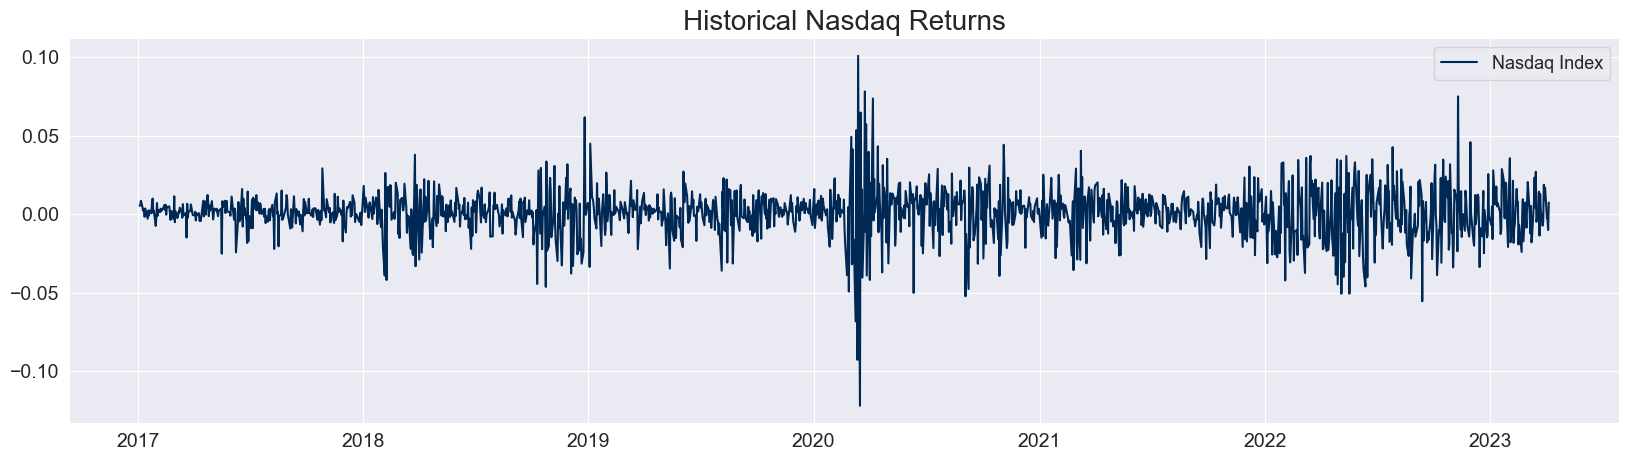

In [832]:
plt.figure(figsize=(20, 5))
plt.title("Historical Nasdaq Returns")
plt.plot(nasdaq_index_df["datetime"], nasdaq_index_df["nasdaqd_ret"])
plt.legend(["Nasdaq Index"])
plt.show()

---
### Euro to Dollar Exchange Rates

In [102]:
euro_dollar_index_df = pd.read_excel(macrodata_path + "/eur_dollar_spotprice.xlsx")

In [103]:
euro_dollar_index_df = euro_dollar_index_df.rename(columns = {"Exchange Date" : "datetime",
                                                      "Refresh Rate": "eur_doll_refresh_rate", 
                                                      "high" : "eur_doll_high",
                                                      "low" : "eur_doll_low",
                                                      "open" : "eur_doll_open",
                                                      "bidnet" : "euro_doll_bidnet",
                                                      "bid" : "euro_doll_bid",
                                                      "ask" : "euro_doll_ask", 
                                                      })
euro_dollar_index_df = euro_dollar_index_df.rename(columns = str.lower)
euro_dollar_index_df['datetime'] = pd.to_datetime(euro_dollar_index_df['datetime'])
euro_dollar_index_df = euro_dollar_index_df[euro_dollar_index_df["datetime"] <= "2023-02-28"]

In [104]:
euro_dollar_index_df

,datetime,bid,ask,high,low,open,eur_doll_refresh_rate,bidnet
28,2023-02-28,1.0576,1.0580,1.0645,1.0572,1.0603,86736.0,-0.0031
29,2023-02-27,1.0607,1.0611,1.0619,1.0531,1.0540,84549.0,0.0061
30,2023-02-24,1.0546,1.0550,1.0614,1.0534,1.0595,65876.0,-0.0049
31,2023-02-23,1.0595,1.0598,1.0627,1.0575,1.0603,67058.0,-0.0006
32,2023-02-22,1.0601,1.0605,1.0663,1.0597,1.0646,74530.0,-0.0045
...,...,...,...,...,...,...,...,...
1630,2017-01-06,1.0530,1.0536,1.0621,1.0520,1.0603,92864.0,-0.0073
1631,2017-01-05,1.0603,1.0611,1.0615,1.0478,1.0489,103626.0,0.0117
1632,2017-01-04,1.0486,1.0490,1.0499,1.0387,1.0403,91660.0,0.0082
1633,2017-01-03,1.0404,1.0408,1.0490,1.0339,1.0453,74707.0,-0.0053


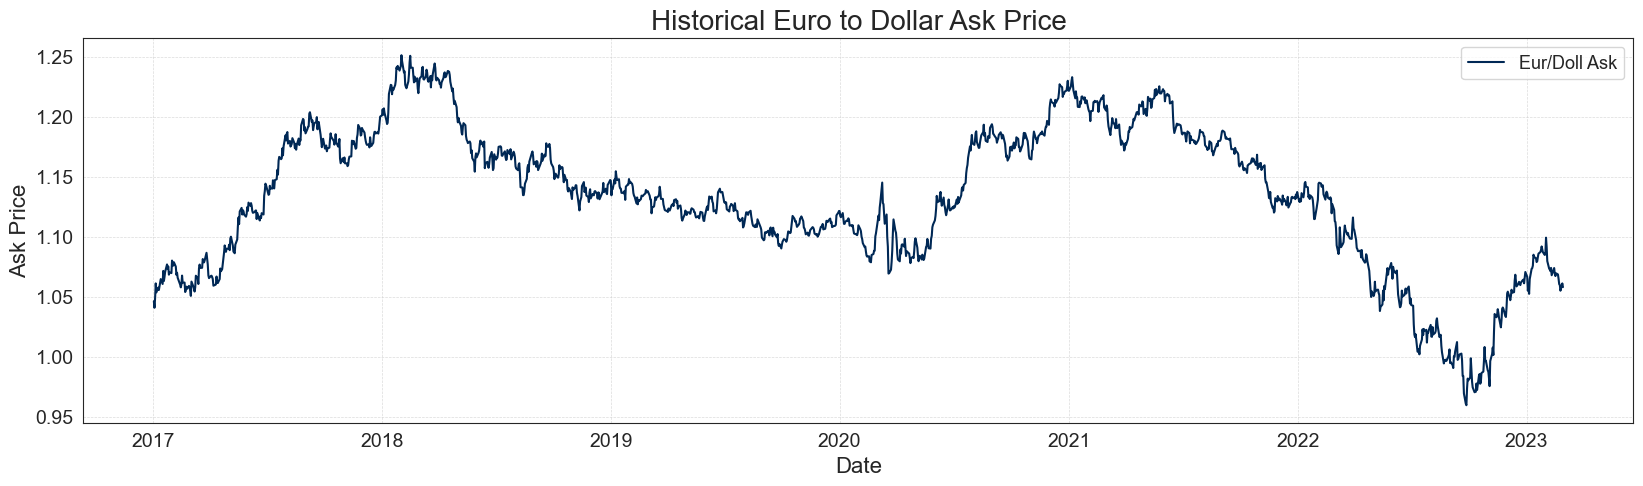

In [114]:
plt.figure(figsize=(20, 5))
plt.title("Historical Euro to Dollar Ask Price")
plt.plot(euro_dollar_index_df["datetime"], euro_dollar_index_df["ask"])
plt.legend(["Eur/Doll Ask"])
plt.xlabel("Date")
plt.ylabel("Ask Price")
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.show()

In [803]:
macro_data_df = pd.merge(euro_dollar_index_df, nasdaq_index_df, how = "inner", on = ["datetime"])

In [804]:
macro_data_df

,datetime,euro_doll_bid,euro_doll_ask,eur_doll_high,eur_doll_low,eur_doll_open,refresh_rate,euro_doll_bidnet,nasdaq_close,nasdaqd_net,nasdaqd_ret,nasdaq_open,nasdaq_low,nasdaq_high,nasdaq_volume
0,2023-02-28,1.0576,1.0580,1.0645,1.0572,1.0603,86736.0,-0.0031,12042.116,-15.672,-0.001300,12041.746,12021.321,12146.523,316618321
1,2023-02-27,1.0607,1.0611,1.0619,1.0531,1.0540,84549.0,0.0061,12057.788,88.136,0.007363,12106.792,12034.613,12159.638,225910837
2,2023-02-24,1.0546,1.0550,1.0614,1.0534,1.0595,65876.0,-0.0049,11969.652,-210.488,-0.017281,11979.799,11900.839,12018.321,263448425
3,2023-02-23,1.0595,1.0598,1.0627,1.0575,1.0603,67058.0,-0.0006,12180.140,113.868,0.009437,12224.444,12003.306,12227.403,284877502
4,2023-02-22,1.0601,1.0605,1.0663,1.0597,1.0646,74530.0,-0.0045,12066.272,5.974,0.000495,12085.674,12006.038,12156.214,265179372
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1544,2017-01-09,1.0572,1.0576,1.0582,1.0508,1.0537,108645.0,0.0042,5024.899,17.822,0.003559,5013.820,5009.451,5033.321,140374244
1545,2017-01-06,1.0530,1.0536,1.0621,1.0520,1.0603,92864.0,-0.0073,5007.077,42.124,0.008484,4973.868,4957.821,5020.699,131384869
1546,2017-01-05,1.0603,1.0611,1.0615,1.0478,1.0489,103626.0,0.0117,4964.953,27.748,0.005620,4936.355,4935.343,4967.901,140485654
1547,2017-01-04,1.0486,1.0490,1.0499,1.0387,1.0403,91660.0,0.0082,4937.205,25.871,0.005268,4920.792,4919.803,4944.745,141126335


In [806]:
#macro_data_df.to_csv(modelling_data_path+ "/macro_data.csv", index = False)

# End of Notebook
---